# Description

This notebook will look at the results from the classification analyses

In [16]:
import pandas as pd
import numpy as np
import os
import os.path as osp
import getpass
from datetime import datetime
from tqdm.notebook import tqdm
from utils.basics import task_cmap_caps
from utils.basics import PNAS2015_subject_list, PNAS2015_folder, PNAS2015_roi_names_path, PNAS2015_win_names_paths, PRJ_DIR, input_datas, norm_methods
from utils.basics import umap_ms, umap_knns, le_knns,le_ms
import xarray as xr
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


In [2]:
wls = 45
wss = 1.5
tr  = 1.5

# 1. Load Classification Results for LE

As stated in the manuscript, we will only explore classification in a subset of the hyper-parameter space. The next cell defines that subspace

In [5]:
le_cl_dist    = 'correlation'
le_cl_knns    = [knn for knn in le_knns if knn > 50]
le_input_data = 'Original'

Now we load both the F1 values and the coefficients

In [7]:
%%time
LE_F1     = pd.DataFrame(columns=['Subject','Input','Norm','Knn','m','Classifier','F1'])
LE_COEFFS = {}
for clf in 'logisticregression','svc':
    for m in tqdm(le_ms, desc='%s:'%clf):
        for knn in le_cl_knns:
            for nm in norm_methods:
                LE_COEFFS[(nm,knn,m,clf)] = xr.DataArray(dims=['Subject','Dimension','Class'], coords={'Subject':['Procrustes'],'Dimension':['LE'+str(i+1).zfill(4) for i in range(m)],'Class':['BACK','MATH','REST','VIDE']})
                # Load Classification results
                # ===========================
                path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015','Procrustes','Classification','LE',le_input_data,
                                'Procrustes_Craddock_0200.WL045s.WS1.5s.LE_{dist}_k{knn}_m{m}.{nm}.clf_results.{clf}_WindowName.pkl'.format(nm=nm,dist=le_cl_dist,knn=str(knn).zfill(4),
                                                                                                                                            m=str(m).zfill(4),clf=clf,
                                                                                                                                            wls=str(int(wls)).zfill(3), 
                                                                                                                                            wss=str(wss)))
                if osp.exists(path):
                    with open(path,'rb') as f:
                        objects = pickle.load(f)
                    locals().update(objects)
                else:
                    print ('++ WARNING: Missing file [%s]' % path)
                # Gather overall F1 - score
                # =========================
                LE_F1 = LE_F1.append({'Subject':'Procrustes',
                                              'Input':le_input_data,
                                              'Norm':nm,
                                              'Knn':knn,
                                              'm':m,
                                              'Classifier':clf,
                                              'F1':cv_obj['test_f1_weighted'].mean()}, ignore_index=True)
                
                # Coefficients
                # ============
                df_coeffs = pd.DataFrame(columns=['Split','Class','Dimension','Coef'])
                for split in range(2):
                    aux_class = list(lab_encs['Window Name'].inverse_transform(cv_obj['estimator'][split][clf].classes_))
                    aux_coef  = cv_obj['estimator'][split][clf].coef_
                    for ci,c in enumerate(aux_class):
                        for i in range(aux_coef.shape[1]):
                            df_coeffs = df_coeffs.append({'Split':split,'Class':c,'Dimension':feature_list[i],'Coef':abs(aux_coef[ci][i])},ignore_index=True)
                df_coeffs = df_coeffs.groupby(by=['Class','Dimension']).mean()
                df_coeffs.reset_index(inplace=True)
                df_coeffs = df_coeffs.pivot(index='Class',columns='Dimension',values='Coef').T
                LE_COEFFS[(nm,knn,m,clf)].loc['Procrustes',:,:] = df_coeffs
                del df_coeffs

logisticregression::   0%|          | 0/8 [00:00<?, ?it/s]

svc::   0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 2min 54s, sys: 1.34 s, total: 2min 55s
Wall time: 3min 18s


# 2. Plot Classification Results for LE
The next cell plots Classification Accuracy as a function of number of dimensions used as input features

(0.0, 1.0)

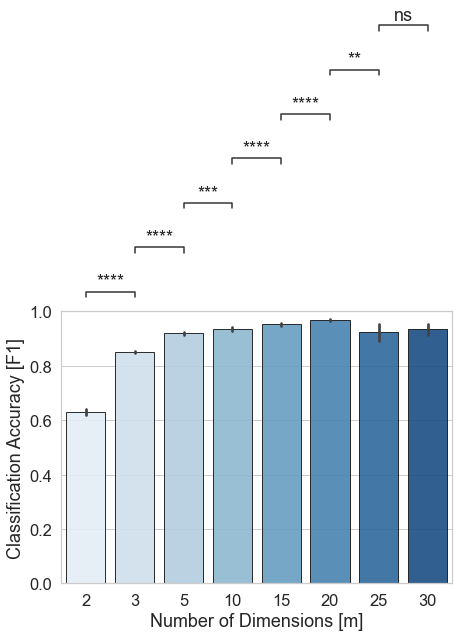

In [56]:
sns.set(font_scale=1.5, style='whitegrid')
fig, ax = plt.subplots(1,1,figsize=(7,5))
data = LE_F1.set_index('Classifier').sort_index().loc['logisticregression']
data['m'] = data['m'].astype(str)
g = sns.barplot(data=data,y='F1',x='m', alpha=.9, palette=sns.color_palette('Blues',8), edgecolor='k')
ax.set_xlabel('Number of Dimensions [m]')
ax.set_ylabel('Classification Accuracy [F1]')
pairs = [(("2"),("3")),(("3"),("5")),(("5"),("10")),(("10"),("15")),(("15"),("20")),(("20"),("25")),(("25"),("30"))]

annot = Annotator(g, pairs, data=data, y='F1',x='m')
annot.configure(test='t-test_paired', verbose=0, comparisons_correction='fdr_bh', text_format="star", loc='outside')
annot.apply_test()
annot.annotate()
ax.set_ylim(0,1)


The next cell plots the average contribution of the different dimensions to the classifier

Text(0, 0.5, 'Logistic Regression Coefficients')

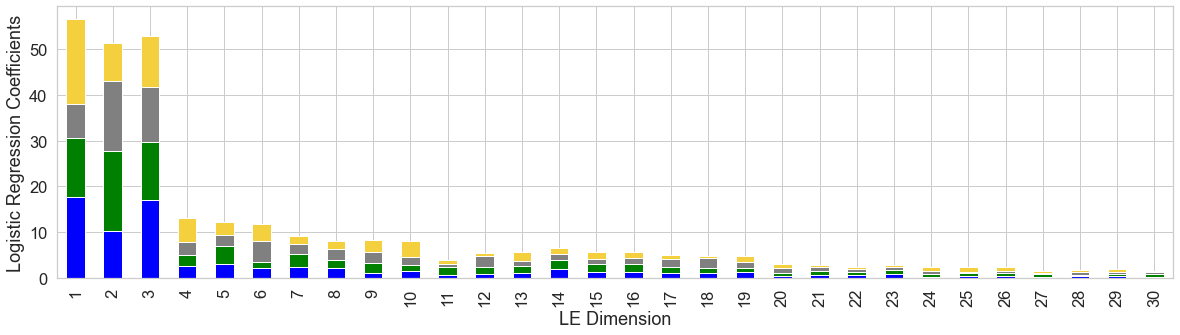

In [35]:
sns.set(font_scale=1.5, style='whitegrid')
fig, ax = plt.subplots(1,1,figsize=(20,5))
df_summary = None
for knn in le_cl_knns:
    for nm in norm_methods:
        aux = LE_COEFFS[(nm,knn,30,'logisticregression')].mean(dim='Subject').to_dataframe(name='Coeffs')
        if df_summary is None:
            df_summary = aux
        else:
            df_summary = pd.concat([aux,df_summary],axis=1)
df_summary = pd.DataFrame(df_summary.mean(axis=1))
df_summary.columns = ['Coeffs']
df_summary.reset_index(inplace=True)
df_summary = df_summary.pivot(index='Class',columns='Dimension',values='Coeffs').T
df_summary.index = [str(i+1) for i in range(30)]
df_summary.index.name = 'LE Dimension'
df_summary.plot(kind='bar',stacked=True, legend=None, color=task_cmap_caps, ax=ax)
ax.set_ylabel('Logistic Regression Coefficients')

***
# 3. Load UMAP Classification Results

Here we are also restricting analyses to a subset of the hyper-parameter space. We set this on the cell below

In [40]:
umap_cl_dist, umap_cl_alpha, umap_cl_mdist = 'euclidean',0.01, 0.8
umap_cl_knns                = [knn for knn in umap_knns if knn > 50]
umap_input_data             = 'Original'

In [41]:
%%time
UMAP_F1     = pd.DataFrame(columns=['Subject','Input','Norm','Knn','m','Classifier','F1'])
UMAP_COEFFS = {}
for clf in 'logisticregression','svc':
    for m in tqdm([2,3,5,10,15,20,25,30], desc='%s:'%clf):
        for knn in umap_cl_knns:
            for nm in norm_methods:
                UMAP_COEFFS[(nm,knn,m,clf)] = xr.DataArray(dims=['Subject','Dimension','Class'], coords={'Subject':['Procrustes'],'Dimension':['UMAP'+str(i+1).zfill(4) for i in range(m)],'Class':['BACK','MATH','REST','VIDE']})
                # Load Classification results
                # ===========================
                path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015','Procrustes','Classification','UMAP',umap_input_data,
                            'Procrustes_Craddock_0200.WL{wls}s.WS{wss}s.LE_{dist}_k{knn}_m{m}.{nm}.clf_results.{clf}_WindowName.pkl'.format(nm=nm,dist=umap_cl_dist,knn=str(knn).zfill(4),
                                                                                                                                            m=str(m).zfill(4),md=str(umap_cl_mdist),clf=clf,
                                                                                                                                            alpha=str(umap_cl_alpha),
                                                                                                                                            wls=str(int(wls)).zfill(3), 
                                                                                                                                            wss=str(wss)))
                with open(path,'rb') as f:
                    objects = pickle.load(f)
                locals().update(objects)
                # Gather overall F1 - score
                # =========================
                UMAP_F1 = UMAP_F1.append({'Subject':'Procrustes',
                                              'Input':umap_input_data,
                                              'Norm':nm,
                                              'Knn':knn,
                                              'm':m,
                                              'Classifier':clf,
                                              'F1':cv_obj['test_f1_weighted'].mean()}, ignore_index=True)
                
                # Coefficients
                # ============
                df_coeffs = pd.DataFrame(columns=['Split','Class','Dimension','Coef'])
                for split in range(2):
                    aux_class = list(lab_encs['Window Name'].inverse_transform(cv_obj['estimator'][split][clf].classes_))
                    aux_coef  = cv_obj['estimator'][split][clf].coef_
                    for ci,c in enumerate(aux_class):
                        for i in range(aux_coef.shape[1]):
                            df_coeffs = df_coeffs.append({'Split':split,'Class':c,'Dimension':feature_list[i],'Coef':abs(aux_coef[ci][i])},ignore_index=True)
                df_coeffs = df_coeffs.groupby(by=['Class','Dimension']).mean()
                df_coeffs.reset_index(inplace=True)
                df_coeffs = df_coeffs.pivot(index='Class',columns='Dimension',values='Coef').T
                UMAP_COEFFS[(nm,knn,m,clf)].loc['Procrustes',:,:] = df_coeffs
                del df_coeffs

logisticregression::   0%|          | 0/8 [00:00<?, ?it/s]

svc::   0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 2min 51s, sys: 1.3 s, total: 2min 52s
Wall time: 3min 24s


# 4. Plots UMAP Classification Results

Text(26.75, 0.5, 'Classification Accuracy [F1]')

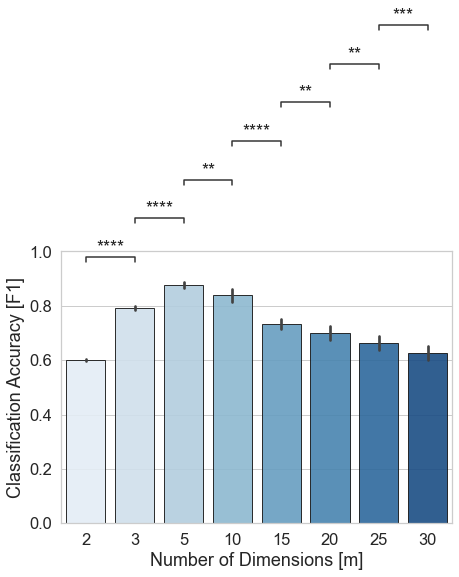

In [54]:
sns.set(font_scale=1.5, style='whitegrid')
fig, ax = plt.subplots(1,1,figsize=(7,5))
data = UMAP_F1.set_index('Classifier').sort_index().loc['logisticregression']
data['m'] = data['m'].astype(str)
g = sns.barplot(data=data,y='F1',x='m', alpha=.9, palette=sns.color_palette('Blues',8), edgecolor='k')
pairs = [(("2"),("3")),(("3"),("5")),(("5"),("10")),(("10"),("15")),(("15"),("20")),(("20"),("25")),(("25"),("30"))]

annot = Annotator(g, pairs, data=data, y='F1',x='m')
annot.configure(test='t-test_paired', verbose=0, comparisons_correction='fdr_bh', text_format="star", loc='outside', text_offset=0)
annot.apply_test()
annot.annotate()
ax.set_ylim(0,1)
ax.set_xlabel('Number of Dimensions [m]')
ax.set_ylabel('Classification Accuracy [F1]')

Text(0, 0.5, 'Logistic Regression Coefficients')

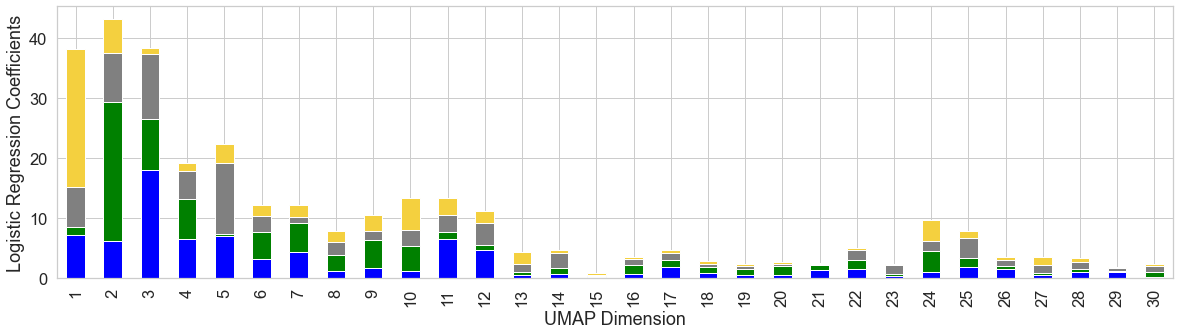

In [57]:
sns.set(font_scale=1.5, style='whitegrid')
fig, ax = plt.subplots(1,1,figsize=(20,5))
df_summary = None
for knn in umap_cl_knns:
    aux = UMAP_COEFFS[('asis',knn,30,'logisticregression')].mean(dim='Subject').to_dataframe(name='Coeffs')
    if df_summary is None:
        df_summary = aux
    else:
        df_summary = pd.concat([aux,df_summary],axis=1)
df_summary = pd.DataFrame(df_summary.mean(axis=1))
df_summary.columns = ['Coeffs']
df_summary.reset_index(inplace=True)
df_summary = df_summary.pivot(index='Class',columns='Dimension',values='Coeffs').T
df_summary.index = [str(i+1) for i in range(30)]
df_summary.index.name = 'UMAP Dimension'
df_summary.plot(kind='bar',stacked=True, legend=None, color=task_cmap_caps, ax=ax)
ax.set_ylabel('Logistic Regression Coefficients')